In [1]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA

import pandas as pd
import seaborn as sn

import matplotlib.pyplot as plt
import numpy as np

from imgaug import augmenters as iaa

# 1. Dlaczego dokonujemy selekcji atrybutów?
### Przekleństwo wymiarowości – nadmiernego dopasowania (overfitting)
    Jeśli będziemy mieć więcej danych w kolumnach niż wierszy, będziemy mogli idealnie dopasować nasze dane testowe, ale nie przełożymy tego dopasowania na nowe próbki. W ten sposób nie nauczymy się absolutnie niczego.
    
### Brzytwa Ockhama
    Chcemy, by nasze modele były proste i możliwe do wytłumaczenia. Tracimy możliwość wytłumaczenia czegoś w prosty sposób, gdy mamy za dużo danych.
    
### Śmieci na wejściu – śmieci na wyjściu
    W większości przypadków będziemy mieć wiele atrybutów, które nie mają znaczenia. Na przykład zmienne Name lub ID. Niska jakość danych wejściowych spowoduje, że dane wyjściowe też będą niskiej jakości.

### Wagi cech na podstawie logistic regression

In [2]:
wdbc = fetch_openml("wdbc", data_home="./wdbc", cache=True)

Aby poprawnie obliczyć wagi potrzebujemy danych w postaci znormalizowanej:

In [3]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(wdbc.data)
train_x, test_x, train_y, test_y = train_test_split(scaled_data, wdbc.target, test_size = 0.2)
scaler.fit(train_x)
train_x = MinMaxScaler().fit_transform(train_x)
test_x = MinMaxScaler().fit_transform(test_x)

Wagi cech obliczamy używając regresji logicznej:

<BarContainer object of 30 artists>

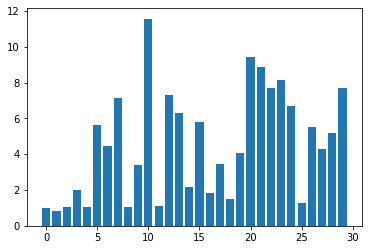

In [4]:
classifier = LogisticRegression(random_state = 0, C=100)
classifier.fit(train_x, train_y)
coef_y = np.abs(classifier.coef_[0])
coef_x = np.arange(len(coef_y))
plt.bar(coef_x,coef_y)

Na powyższym wykresie możemy zaobserwować, że spora część cech jest właściwie pomijalna.

# 2. Metody selekcji cech
### Chi-kwadrat
Jest metodą opartą na filtrach, w której obliczamy metrykę chi-kwadrat między wartością docelową a zmienną numeryczną i wybieramy tylko zmienną o maksymalnych wartościach chi-kwadrat.

Aby obliczć wartość Chi-kwadrat najpierw przyjmujemy wartość, której byśmy się spodziewali w każdym segmencie, gdyby faktycznie nie istniała zależność między dwiema kategoriami zmiennych. To proste. Mnożymy sumę wierszy i sumę kolumn dla każdej komórki i dzielimy ją przez liczbę całkowitą.

In [5]:
def chi_selector(X, y, num_feats):
    X = df = pd.DataFrame(data=X)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X, y)
    chi_support = chi_selector.get_support().tolist()
    chi_feature = X.loc[:,chi_support].columns.tolist()
    return chi_feature


### Rekurencyjna eliminacja cech
Rekurencyjnej eliminacji cech (RFE) polega na selekcji poprzez rekurencyjne uwzględnianie coraz mniejszych zestawów atrybutów. Najpierw estymator jest szkolony na początkowym zestawie atrybutów, a znaczenie każdego z nich uzyskiwane jest albo przez atrybut coef_ lub poprzez atrybut feature_importance_. Następnie, najmniej ważne atrybuty są usuwane z bieżącego zestawu. Tę procedurę powtarza się rekurencyjnie, aż w końcu zostanie osiągnięta potrzebna nam ilość atrybutów do wyboru.

In [6]:
def rfe(X, y, num_feats): 
    df = pd.DataFrame(data=X)
    rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
    rfe_selector.fit(X_norm, y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X.loc[:,rfe_support].columns.tolist()
    return rfe_feature

Aby sprawdzić jak wybór cech wpływa na dokładność wyników wykorzystamy algorytm k najbliższych sąsiadów

In [7]:
def knn_feats(neighbors, columns):
    columns = np.array([1,2,3])
    knn = KNeighborsClassifier(n_neighbors = neighbors)
    knn.fit(train_x[:, columns], train_y)
    pred_y = knn.predict(test_x[:, columns])
    print("Prediction accuracy with k =", neighbors, "and m =", columns, ":", accuracy_score(test_y, pred_y))


In [8]:
m = 3 # liczba cech
k = 3 # liczba sąsiadów
feats = np.array(chi_selector(train_x, train_y, m))
knn_feats(k, feats)
print(feats)


Prediction accuracy with k = 3 and m = [1 2 3] : 0.8947368421052632
[ 6  7 27]


# 3. Kowariancja

Kowariancja stanowi miarę siły korelacji między dwiema  lub większa ilością zmiennych. Element macierzy kowariancji Cij jest kowariancją xi i xj. Element Cii jest wariantem Xi.

     Jeśli COV(xi, xj) = 0, to zmienne są nieskorelowane
     Jeśli COV(xi, xj) > 0, to zmienne są dodatnio skorelowane
     Jeśli COV(xi, xj) < 0, to zmienne są ujemnie skorelowane

In [9]:
import numpy as np 
  
x = np.array([[0, 3, 4], [1, 2, 4], [3, 4, 5]]) 

print("Wymiar macierzy:", np.shape(x)) 
print("Macierz kowariancji x:\n", np.cov(x)) 

Wymiar macierzy: (3, 3)
Macierz kowariancji x:
 [[4.33333333 2.83333333 2.        ]
 [2.83333333 2.33333333 1.5       ]
 [2.         1.5        1.        ]]


In [10]:
x = [1.23, 2.12, 3.34, 4.5] 
y = [2.56, 2.89, 3.76, 3.95] 
  
# find out covariance with respect rows 
cov_mat = np.stack((x, y), axis = 1)
print(cov_mat)
  
print("Wymiar macierzy x i y:", np.shape(cov_mat)) 
np_cov_mat = np.cov(cov_mat)
print("Wymiar macierzy kowariancji:", np.shape(np_cov_mat)) 
print(np_cov_mat) 

[[1.23 2.56]
 [2.12 2.89]
 [3.34 3.76]
 [4.5  3.95]]
Wymiar macierzy x i y: (4, 2)
Wymiar macierzy kowariancji: (4, 4)
[[ 0.88445  0.51205  0.2793  -0.36575]
 [ 0.51205  0.29645  0.1617  -0.21175]
 [ 0.2793   0.1617   0.0882  -0.1155 ]
 [-0.36575 -0.21175 -0.1155   0.15125]]


Heatmap, czyli graficzna reprezentacja macierzy kowariancji:

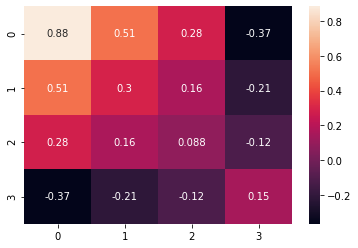

In [11]:
import seaborn as sn

sn.heatmap(np_cov_mat, annot=True, fmt='.2g')

# 4. Analiza głównych składowych - PCA

Zbiór danych składający się z N obserwacji, z których każda obejmuje K zmiennych, można interpretować jako chmurę N punktów w przestrzeni K-wymiarowej. Celem PCA jest taki obrót układu współrzędnych, aby maksymalizować w pierwszej kolejności wariancję pierwszej współrzędnej, następnie wariancję drugiej współrzędnej itd.. 

PCA może być oparte albo na macierzy korelacji, albo macierzy kowariancji utworzonej ze zbioru wejściowego. Algorytm w obydwu wersjach jest poza tym identyczny, jednak różne są uzyskane wyniki. W przypadku użycia macierzy kowariancji, zmienne w zbiorze wejściowym o największej wariancji mają największy wpływ na wynik, co może być wskazane, jeśli zmienne reprezentują porównywalne wielkości, np. procentowe zmiany kursów różnych akcji. Użycie macierzy korelacji natomiast odpowiada wstępnej normalizacji zbioru wejściowego tak, aby każda zmienna miała na wejściu identyczną wariancję, co może być wskazane, jeśli wartości zmiennych nie są porównywalne. 

Przykładowe dane:

In [12]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
# load dataset into Pandas DataFrame
df = pd.read_csv(url, names=['sepal length','sepal width','petal length','petal width','target'])

In [13]:
df

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


Przed zastosowaniem PCA należy przeskalować zbiór danych. W tym celu użyjemy StandardScaler

In [14]:
from sklearn.preprocessing import StandardScaler
features = ['sepal length', 'sepal width', 'petal length', 'petal width']
# Separating out the features
x = df.loc[:, features].values
# Separating out the target
y = df.loc[:,['target']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

Oryginalne dane mają 4 kolumny (sepal length, sepal width, petal length i petal width). Poniższy kod wyświetla oryginalne dane, które są zamienione z 4-wymiarowych na 2-wymiarowe. 

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['Główny składnik 1', 'Główny składnik 2'])
principalDf

,Główny składnik 1,Główny składnik 2
0,-2.264542,0.505704
1,-2.086426,-0.655405
2,-2.367950,-0.318477
3,-2.304197,-0.575368
4,-2.388777,0.674767
...,...,...
145,1.870522,0.382822
146,1.558492,-0.905314
147,1.520845,0.266795
148,1.376391,1.016362


finalDf jest ostatecznym DataFrame przed stworzeniem wykresu.

In [16]:
finalDf = pd.concat([principalDf, df[['target']]], axis = 1)
finalDf

,Główny składnik 1,Główny składnik 2,target
0,-2.264542,0.505704,Iris-setosa
1,-2.086426,-0.655405,Iris-setosa
2,-2.367950,-0.318477,Iris-setosa
3,-2.304197,-0.575368,Iris-setosa
4,-2.388777,0.674767,Iris-setosa
...,...,...,...
145,1.870522,0.382822,Iris-virginica
146,1.558492,-0.905314,Iris-virginica
147,1.520845,0.266795,Iris-virginica
148,1.376391,1.016362,Iris-virginica


# 5. Porównanie wyników klasyfikatora knn
W tym punkcie porównamy dokładność klasyfikatora knn dla różnych wartości parametru k na oryginalnych cechach oraz na cechach wybranych przez PCA. Wykorzystamy do tego zbiór danych związanych z diagnozą raka piersi z Wisconsin.

In [17]:
wdbc = fetch_openml("wdbc", data_home="./wdbc", cache=True)

Tak, jak poprzednio, stosowanie algorytmu PCA wymaga normalizacji danych

In [18]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(wdbc.data)
train_x, test_x, train_y, test_y = train_test_split(scaled_data, wdbc.target, test_size = 0.2)
scaler.fit(train_x)
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)


Najpierw sprawdzamy dokładność dla "starych" cech:

In [19]:
def z5_test(neighbors, columns):
    knn = KNeighborsClassifier(n_neighbors = neighbors)
    knn.fit(train_x[:, :columns], train_y)

    pred_y = knn.predict(test_x[:, :columns])
    print("Prediction accuracy with k =", neighbors, "and m =", columns, ":", accuracy_score(test_y, pred_y))

z5_test(1, 2)

Prediction accuracy with k = 1 and m = 2 : 0.8596491228070176


By wykorzystać transformację PCA wystarczy użyć klasy `PCA` z pakietu `scikit-learn`.

In [20]:
pca = PCA()
pca.fit(train_x)

def z5_test(neighbors, columns):
    knn = KNeighborsClassifier(n_neighbors = neighbors)
    knn.fit(pca.transform(train_x)[:, :columns], train_y)

    pred_y = knn.predict(pca.transform(test_x)[:, :columns])
    print("Prediction accuracy with k =", neighbors, "and m =", columns, ":", accuracy_score(test_y, pred_y))

z5_test(1, 2)

Prediction accuracy with k = 1 and m = 2 : 0.9122807017543859


Jak widać zastosowanie PCA stanowczo poprawia jakość klasyfikatora. Korzystając z powyższych komórek wypełnij poniższe tabele:

Dokładność dla "starych" danych wejściowych:

| k     | m = N | m = 5 | m = 2 |
|-------|-------|-------|-------|
| 1 |       |       | 85.96%      |
| 3 |       |       |       |
| 5 |       |       |       |

Dokładność dla "nowych" danych wejściowych:

| k     | m = N | m = 5 | m = 2 |
|-------|-------|-------|-------|
| 1 |       |       | 93.86%       |
| 3 |       |       |       |
| 5 |       |       |       |

# 6. Wizualizacja zbioru

Algorytm PCA pozwala również na łatwą wizualizację danych. Dzięki redukcji wymiarów wielowymiarowy zbiór danych
można przedstawić na dwu lub trójwymiarowym rysunku, tracąc przy tym możliwie najmniej informacji.

Na poniższym grafie przedstawiamy dwie różne klasy ze sbioru wejściowego kolorami zielonym i niebieskim.
Kolorem czerwonym zaznaczone zostały dane źle zaklasyfikowane.

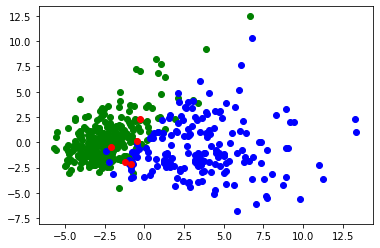

In [21]:
reduced_x = pca.transform(train_x)[:, :2]
benign_i = []
malign_i = []
for i in range(len(reduced_x)):
    if int(train_y[i]) == 1:
        benign_i.append(i)
    else:
        malign_i.append(i)

plt.scatter(reduced_x[benign_i, 0], reduced_x[benign_i, 1], color = "green")
plt.scatter(reduced_x[malign_i, 0], reduced_x[malign_i, 1], color = "blue")

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(reduced_x, train_y)
red_test_x = pca.transform(test_x)[:, :2]
pred_y = knn.predict(red_test_x)

wrong_i = []

for i in range(len(pred_y)):
    if pred_y[i] != test_y[i]:
        wrong_i.append(i)

plt.scatter(red_test_x[wrong_i, 0], red_test_x[wrong_i, 1], color = "red")
    

Na wykresie widać, że nawet w tylko dwóch wymiarach klasy są dosyć dobrze rozdzielone.
Również zgodnie z przewidywaniami źle zaklasyfikowane przykłady (czerwone kropki) leżą blisko granicy dwóch klas.

W wielu analizach statystycznych przydatna jest wiedza o tzw. Outlierach, to znaczy przypadkach oddalonych od innych, które mogą oznaczać błąd pomiaru lub wyjątkowo żadkie warunki. 

W pakiecie scikit istnieje kilka algorytmów do ich znajdywania:

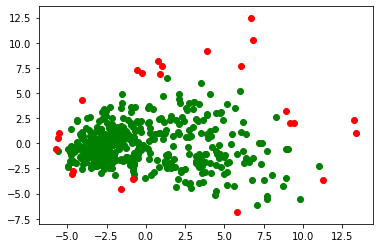

In [22]:
from sklearn.neighbors import LocalOutlierFactor

estimator = LocalOutlierFactor()
outliers = estimator.fit_predict(reduced_x)

inlier_i = []
outlier_i = []

for i in range(len(reduced_x)):
    if int(outliers[i]) == 1:
        inlier_i.append(i)
    else:
        outlier_i.append(i)

plt.scatter(reduced_x[inlier_i, 0], reduced_x[inlier_i, 1], color = "green")
plt.scatter(reduced_x[outlier_i, 0], reduced_x[outlier_i, 1], color = "red")

Na zielono zaznaczone są "normalne" dane (tzw. Inliers) a na czerwono punkty, które zostały wykryte jako wyjątkowe (Outliers).

Jeśli chcesz, możesz wypróbować inne algorytmy wykrywania outlierów, do tego celu zmień `neighbors.LocalOutlierFactor` na jeden z: `ensemble.IsolationForest`, `svm.OneClassSVM` lub `covariance.EllipticEnvelope`

## 7. Zadanie do wykonania.
Celem zadania wykonanego w ramach dzisiejszych laboratoriów będzie praktyczne zaobserwowanie wpływu selekcji cech na wynik klasyfikacji k-nn, jak również porównanie efektów augmentacji danych i inżynierii cech. **W tym celu posłużymy się zbiorami danych MNIST, NMIST oraz CIFAR-10.**

Poniżej przytoczyliśmy kolejne polecenia wraz z przykładami dla podzbioru MNIST. Liczbę przykładów dobieramy w ten sposób, by była nie większa niż dwukrotność liczby cech (w naszym przypadku: pikseli).

In [23]:
mnist = fetch_openml("mnist_784", data_home="./mnist_784", cache=True)

In [24]:
samples = 1500 # < 2 * 28 * 28

mnist_data = mnist.data[:samples]
mnist_target = mnist.target[:samples]

In [25]:
mnist_train_data, mnist_test_data, mnist_train_labels, mnist_test_labels = train_test_split(mnist_data, mnist_target, train_size=0.75, random_state=0)

### 7.1. Znalezienie najmniej informatywnych cech.
Zaczniemy od znalezienia `m` najmniej informatywnych cech badanych danych, a więc pikseli, które w najmniejszym stopniu wpływają na klasyfikację obrazków ze zbioru. Wyznaczone cechy zwizualizujemy w formie rysunku odpowiadającego wymiarem klasyfikowanym obrazom.

In [26]:
k = 3                            # Liczba sąsiadów
m = 400                          # Liczba najmniej informatywnych cech, jakie chcemy znaleźć
total_features = 28 * 28

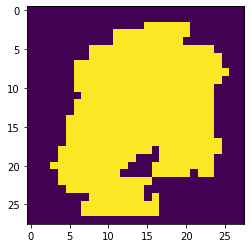

In [27]:
feature_selector = SelectKBest(chi2, k=total_features-m)
feature_selector.fit(mnist_train_data, mnist_train_labels)
selection = feature_selector.get_support()

selection_preview = selection
selection_preview = np.array(selection_preview).reshape(28, 28)
plt.imshow(selection_preview)

### 7.2. Porównanie wyników klasyfikacji k-NN.
Porównamy wyniki klasyfikacji k-NN przeprowadzonej dla pełnego zbioru oraz dla zbioru po usunięciu `m` najmniej informatywnych cech.

In [28]:
knn_all = KNeighborsClassifier(n_neighbors = k)
knn_all.fit(mnist_train_data, mnist_train_labels)
prediction1 = knn_all.predict(mnist_test_data)
accuracy1 = accuracy_score(prediction1, mnist_test_labels)
print("Dla pełnego zbioru miara dokładności wynosi:", accuracy1)

Dla pełnego zbioru miara dokładności wynosi: 0.8746666666666667


In [29]:
mnist_train_reduced = feature_selector.transform(mnist_train_data)
mnist_test_reduced = feature_selector.transform(mnist_test_data)

knn_some = KNeighborsClassifier(n_neighbors = k)
knn_some.fit(mnist_train_reduced, mnist_train_labels)
prediction2 = knn_some.predict(mnist_test_reduced)
accuracy2 = accuracy_score(prediction2, mnist_test_labels)
print("Dla zbioru po odrzuceniu", m, "najmniej informatywnych cech miara dokładności wynosi:", accuracy2)

Dla zbioru po odrzuceniu 400 najmniej informatywnych cech miara dokładności wynosi: 0.8853333333333333


### 7.3. Transformacja przy użyciu PCA.
Przy pomocy analizy głównych składowych transformujemy dane z wektorów N-wymiarowych w N-wymiarowe.

In [30]:
# Przed zastosowaniem PCA musimy zadbać o normalizację danych.
scaler = StandardScaler()
scaler.fit(mnist_train_data)

mnist_train_data = scaler.transform(mnist_train_data)
mnist_test_data = scaler.transform(mnist_test_data)

In [31]:
pca = PCA() # Nie ograniczamy liczby składowych.
pca.fit(mnist_train_data)

transformed_train_data = pca.transform(mnist_train_data)
transformed_test_data = pca.transform(mnist_test_data)

Dokonujemy wizualizacji wektorów własnych odpowiadających największym wartościom własnym.

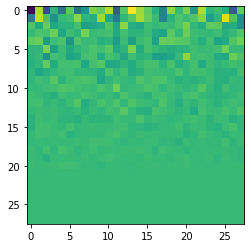

In [32]:
plt.imshow(np.array(transformed_train_data[0]).reshape(28, 28))

Sprawdzamy, czy poprawił się wynik klasyfikacji. Dlaczego?

In [33]:
knn = KNeighborsClassifier(n_neighbors = k)
knn.fit(mnist_train_data, mnist_train_labels)
prediction = knn.predict(mnist_test_data)
accuracy = accuracy_score(prediction, mnist_test_labels)
print("Miara dokładności wynosi:", accuracy)

Miara dokładności wynosi: 0.8133333333333334


In [34]:
knn = KNeighborsClassifier(n_neighbors = k)
knn.fit(transformed_train_data, mnist_train_labels)
prediction = knn.predict(transformed_test_data)
accuracy = accuracy_score(prediction, mnist_test_labels)
print("Miara dokładności wynosi:", accuracy)

Miara dokładności wynosi: 0.8133333333333334


Dokonajmy wizualizacji 2D przy pomocy PCA.

In [35]:
colors = ['#0D3C55', '#1395BA', '#5CA793', '#A2B86C', '#EBC844', '#ECAA38', '#EF8B2C', '#F16C20', '#D94E1F', '#C02E1D']

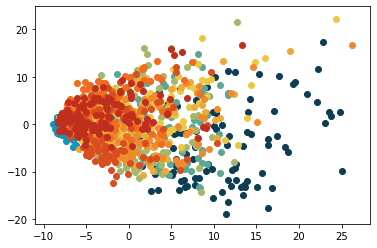

In [36]:
visualized_data = transformed_train_data[:, :2]
visualized_labels = mnist_train_labels

cluster_count = len(set(mnist_train_labels))
clusters = [[] for i in range(cluster_count)]

for i in range(len(visualized_data)):
    cluster_id = int(visualized_labels[i])
    clusters[cluster_id].append(i)
    
for cluster_id in range(len(clusters)):
    cluster = clusters[cluster_id]
    plt.scatter(visualized_data[cluster, 0], visualized_data[cluster, 1], color=colors[cluster_id])

### 7.4. Obserwacja efektów selekcji cech z użyciem PCA.
Usuń `m` najmniej informatywnych cech PCA (gdzie m jest duże, np. rzędu 500 dla 784 cech). Porównaj wynik klasyfikacji.

In [37]:
m = 500
total_features = 28 * 28
left = total_features - m

In [38]:
reduced_train_data = pca.transform(mnist_train_data)[:, :left]
reduced_test_data = pca.transform(mnist_test_data)[:, :left]

knn = KNeighborsClassifier(n_neighbors = k)
knn.fit(reduced_train_data, mnist_train_labels)
prediction = knn.predict(reduced_test_data)
accuracy = accuracy_score(prediction, mnist_test_labels)
print("Miara dokładności wynosi:", accuracy)

Miara dokładności wynosi: 0.816


Teraz pozostaw `m` najlepszych cech PCA (gdzie `m` jest małe, rzędu 10-20). Porównaj wynik klasyfikacji.

In [39]:
m = 15

In [40]:
reduced_train_data = pca.transform(mnist_train_data)[:, :m]
reduced_test_data = pca.transform(mnist_test_data)[:, :m]

knn = KNeighborsClassifier(n_neighbors = k)
knn.fit(reduced_train_data, mnist_train_labels)
prediction = knn.predict(reduced_test_data)
accuracy = accuracy_score(prediction, mnist_test_labels)
print("Miara dokładności wynosi:", accuracy)

Miara dokładności wynosi: 0.856


### 7.5. Porównanie efektów augmentacji i inżynierii cech.
Dokonaj klasyfikacji z użyciem PCA.

In [41]:
m = 15
reduced_train_data = pca.transform(mnist_train_data)[:, :m]
reduced_test_data = pca.transform(mnist_test_data)[:, :m]

knn = KNeighborsClassifier(n_neighbors = k)
knn.fit(reduced_train_data, mnist_train_labels)
prediction = knn.predict(reduced_test_data)
accuracy = accuracy_score(prediction, mnist_test_labels)
print("Miara dokładności wynosi:", accuracy)

Miara dokładności wynosi: 0.856


Następnie dokonaj klasyfikacji bez użycia PCA, zwiększając liczbę przykładów z użyciem augmentacji przy użyciu biblioteki `imgaug`.

In [42]:
blur_effect = iaa.GaussianBlur(sigma=(2.0, 3.0))
blurred_images = blur_effect(images=np.reshape(mnist_train_data, (-1, 28, 28)))
blurred_data = np.reshape(blurred_images, (-1,28*28))

augmented_data = np.concatenate((mnist_train_data, blurred_data))
augmented_labels = np.concatenate((mnist_train_labels, mnist_train_labels))

In [43]:
knn = KNeighborsClassifier(n_neighbors = k)
knn.fit(augmented_data, augmented_labels)
prediction = knn.predict(mnist_test_data)
accuracy = accuracy_score(prediction, mnist_test_labels)
print("Miara dokładności wynosi:", accuracy)

Miara dokładności wynosi: 0.872


Porównaj wyniki klasyfikacji w obu przypadkach. Jaki można wysnuć wniosek?